<hr style="border: none; border-top: 2px solid black;" />

---

# RUN DIAGNOSIS NOTEBOOK
---
<hr style="border: none; border-top: 2px solid black;" />



This notebook is created to check main properties of a run taken by LST-1 telescope. Is also valid for runs taken in stereo mode with MAGIC, as far as the joint data in DL2 and DL3 format is provided.

- The code should be run with `lstchain` installed (https://github.com/cta-observatory/cta-lstchain). With the complementary scripts that are found in the same folder of the repository.


##### First of all the following packages need to be imported

In [1]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import sys, os, glob, re, tables
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
pd.set_option("display.max_columns", None)

from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy.visualization.wcsaxes import SphericalCircle
from scipy.stats import chi2, binned_statistic_2d
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

# lstchain  scripts
from ctapipe.coordinates import EngineeringCameraFrame
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import CameraFrame
from lstchain.reco.utils import clip_alt
from traitlets.config import Config
from ctapipe.io import EventSource

# other scripts from the repository
import plotting
import utils

# All parameters:

There are different options to be changed for the script:

* **`run_number`** The run number of the observation to analyse. The LST-1 run number.
<br>
* **`root_data`** The main directory where the higher level data (DL2 and DL3) is stored. This should be changed in the case you computed DL2 or DL3 data of the required run. In the case you have not computed the higher levels of data, just set to `None`.
<br>
* **`source_name`** and **`source_coord`** Name of the source that is being analysed. And the `SkyCoord` object will be computed automatically if the object is in the database, otherwise, input the coordinates manually.
<br>
* **`input_path_dl1`** If the code is run in the IT cluster, this can be set to None and the dl1 path will be the following one, that uses the DL1 produced automatically each night:

    ```/fefs/aswg/data/real/DL1/*/{version_string}/tailcut84/```

    If specific DL1 data is produced, the path can be input.
    <br>

* **`input_path_dl2`** If DL2 data is produced, then input the path. Otherwise some steps will be skipped due to not high level data available.
<br>

* **`input_path_dl3`** If DL2 data is produced, then input the path. Otherwise some steps will be skipped due to not high level data available.
<br>

* **`test_nodes_folders`** The path to the test nodes that are used for DL2 data. If the code is run in the IT cluster, the one provided can be used, as is the later version of MC productions.
<br>

* **`store_plots`** Boolean for saving or not the plot into a subdirectory `./images/`.


In [2]:
# Run number
run_number = 17821

# Source and coordinates
source_name = "S240615dg"
source_coord = SkyCoord(ra=7.53, dec=45.81, unit="deg")

# DL1 path
input_path_dl1 = None # Set to None if you want to use the standard one in IT cluster

# DL2 and DL3 paths
# Path where dl1 and dl2 data is stored
root_data = f"/fefs/aswg/workspace/juan.jimenez/data/{source_name}/"
input_path_dl2 = f"{root_data}DL2/dl2_LST-1.Run{run_number:05}.h5"
# input_path_dl2 = f"{root_data}DL2/dl2_MAGIC_LST-1.Run{run_number:05}.h5"
input_path_dl3 = f"{root_data}DL3/dl3_LST-1.Run{run_number:05}.fits"
# input_path_dl3 = f"{root_data}DL3/dl3_MAGIC_LST-1.Run{run_number:05}.fits.gz"

# MC production nodes path
test_nodes_folders = "/fefs/aswg/data/mc/IRF/AllSky/20240131_allsky_v0.10.5_all_dec_base/TestingDataset/dec_2276/*"

# If the you want to save the plots in a subdirectory
store_plots = False

Then we perform some direct tranformations and manipulations such as defining earth location, that will be the same always that we use LST-CTA data. The keys to the dl1 and dl2 `hdf` data. In this case if joint LST-1 and MAGIC data will be used, it should be changed (maybe to be added automatically in the future).

* For LST-1 mono data:
```key_dl2 = "/dl2/event/telescope/parameters/LST_LSTCam"```

* Fot MAGIC+LST stereo data:
```key_dl2 = "/events/parameters"```

Then the tables and data is extracted from the provided paths, and also the geomtry of LST-camera is read from the DL1 data

In [3]:
%%time
# The location of the observatory
observing_location = EarthLocation.of_site("Roque de los Muchachos")

# The subdirectory for saving the plots
dir_plots = "./images/"

# Exporting ra and dec of the coordinates
source_ra  = source_coord.ra.deg
source_dec = source_coord.dec.deg
source_glon = source_coord.galactic.l.deg
source_glat = source_coord.galactic.b.deg

# --- paths and reading tables --- #
key_dl1 = "/dl1/event/telescope/parameters/LST_LSTCam"
key_dl2 = "/dl2/event/telescope/parameters/LST_LSTCam" #"/events/parameters" # 

# Getting the DL1 filename for the file and the datacheck as well
path_dl1 = utils.find_dl1_fname(run_number) if input_path_dl1 == None else input_path_dl1
path_dl1_dcheck = utils.find_dl1_fname(run_number, dchecking=True, print_details=False)
path_r0 = utils.find_r0_fname(run_number, 0, 1, print_details=True)
path_dl2, path_dl3 = input_path_dl2, input_path_dl3
table_dl1_datacheck, table_dl1, table_dl2 = utils.open_files(globals(), key_dl1, key_dl2)

# Geometry for camera plots
source = EventSource(input_url=path_r0, config=Config(), max_events=1)
camgeom = source.subarray.tel[1].camera.geometry

# Creating a folder for the plots
for path in [dir_plots]:
    os.makedirs(os.path.join(path), exist_ok=True)
    
# Colors for the colormaps
cmap_cols = ["b", "darkviolet", "r"]
colormap = plotting.create_cmap_from_colors(cmap_cols)

DL1 file version: v0.10
CPU times: user 17.9 s, sys: 9.92 s, total: 27.8 s
Wall time: 34.1 s


Then we read all the data. Starting from the datachecks, DL1 tables, and in the case that they are provided, DL2 and DL3.

In [4]:
# Reading datacheck data --------------------------------------------------
# Direct quantities
srun_number = table_dl1_datacheck.cosmics.col("subrun_index")
srun_elapsed_time = table_dl1_datacheck.cosmics.col("elapsed_time")
srun_cumulative_time = np.cumsum(srun_elapsed_time)
srun_num_events = table_dl1_datacheck.cosmics.col("num_events")
srun_num_cleaned_events = table_dl1_datacheck.cosmics.col("num_cleaned_events")
srun_mean_az = np.rad2deg(table_dl1_datacheck.cosmics.col("mean_az_tel"))
srun_tel_ra  = table_dl1_datacheck.cosmics.col("tel_ra")
srun_tel_dec = table_dl1_datacheck.cosmics.col("tel_dec")

# Some manipulations
srun_dragon_time = np.array([f[0] for f in table_dl1_datacheck.cosmics.col("dragon_time")])
srun_charge_mean = np.array([np.mean(f) for f in table_dl1_datacheck.cosmics.col("charge_mean")])
srun_charge_stdv = np.array([np.mean(f) for f in table_dl1_datacheck.cosmics.col("charge_stddev")])
srun_mean_zd = 90 - np.rad2deg(table_dl1_datacheck.cosmics.col("mean_alt_tel"))
srun_num_non_cleaned_events = srun_num_events - srun_num_cleaned_events

# Calculations
srun_rate_events = srun_num_events / srun_elapsed_time
srun_rate_cleaned_events = srun_num_cleaned_events / srun_elapsed_time

# Histogram binnings
columns_binnings = table_dl1_datacheck.histogram_binning.colnames
columns_hist = [col for col in table_dl1_datacheck.cosmics.colnames if "hist_" in col]

bins_hist_intensity = table_dl1_datacheck.histogram_binning.col("hist_intensity")[0]
bins_hist_delta_t = table_dl1_datacheck.histogram_binning.col("hist_delta_t")[0]
bins_hist_npixels = table_dl1_datacheck.histogram_binning.col("hist_npixels")[0]
bins_hist_nislands = table_dl1_datacheck.histogram_binning.col("hist_nislands")[0]
bins_hist_dist0 = table_dl1_datacheck.histogram_binning.col("hist_dist0")[0]
bins_hist_pixelchargespectrum = table_dl1_datacheck.histogram_binning.col("hist_pixelchargespectrum")[0]
bins_hist_psi = table_dl1_datacheck.histogram_binning.col("hist_psi")[0]

hist_intensity = table_dl1_datacheck.cosmics.col("hist_intensity")
hist_delta_t = table_dl1_datacheck.cosmics.col("hist_delta_t")
hist_npixels = table_dl1_datacheck.cosmics.col("hist_npixels")
hist_nislands = table_dl1_datacheck.cosmics.col("hist_nislands")
hist_dist0 = table_dl1_datacheck.cosmics.col("hist_dist0")
hist_pixelchargespectrum = table_dl1_datacheck.cosmics.col("hist_pixelchargespectrum")
hist_psi = table_dl1_datacheck.cosmics.col("hist_psi")

# Extracting also flatfield and pedestal events
# from these we extract the mean charge, dtandard deviation and also for the time of peak
# For flatfield
flatfield_charge_mean = table_dl1_datacheck.flatfield.col("charge_mean")
flatfield_charge_stddev = table_dl1_datacheck.flatfield.col("charge_stddev")
flatfield_time_mean = table_dl1_datacheck.flatfield.col("time_mean")
flatfield_time_stddev = table_dl1_datacheck.flatfield.col("time_stddev")
# For pedestals
pedestals_charge_mean = table_dl1_datacheck.pedestals.col("charge_mean")
pedestals_charge_stddev = table_dl1_datacheck.pedestals.col("charge_stddev")
flatfield_charge_mean_pixel = np.mean(flatfield_charge_mean, axis=0)
flatfield_charge_stddev_pixel = np.mean(flatfield_charge_stddev, axis=0)
flatfield_time_mean_pixel = np.mean(flatfield_time_mean, axis=0)
flatfield_time_stddev_pixel = np.mean(flatfield_time_stddev, axis=0)
pedestals_charge_mean_pixel = np.mean(pedestals_charge_mean, axis=0)
pedestals_charge_stddev_pixel = np.mean(pedestals_charge_stddev, axis=0)
# We average pixel-wise shape=n-sruns
flatfield_charge_mean_srun = np.mean(flatfield_charge_mean, axis=1)
flatfield_charge_stddev_srun = np.mean(flatfield_charge_stddev, axis=1)
flatfield_time_mean_srun = np.mean(flatfield_time_mean, axis=1)
flatfield_time_stddev_srun = np.mean(flatfield_time_stddev, axis=1)
pedestals_charge_mean_srun = np.mean(pedestals_charge_mean, axis=1)
pedestals_charge_stddev_srun = np.mean(pedestals_charge_stddev, axis=1)

# Reading DL1 data --------------------------------------------------
dl1_x, dl1_y = table_dl1["x"], table_dl1["y"]

masknan = ~(np.isnan(dl1_x) | np.isnan(dl1_y)) 
mask_eventtype = table_dl1["event_type"] == 32
dl1_mask = masknan & mask_eventtype

dl1_x, dl1_y = dl1_x[dl1_mask], dl1_y[dl1_mask]
dl1_phi = table_dl1["phi"][dl1_mask]
dl1_r = table_dl1["r"][dl1_mask]
dl1_width = table_dl1["width"][dl1_mask]
dl1_length = table_dl1["length"][dl1_mask]
dl1_psi = table_dl1["psi"][dl1_mask]
dl1_npixels = table_dl1["n_pixels"][dl1_mask]
dl1_concentration_cog = table_dl1["concentration_cog"][dl1_mask]
dl1_concentration_core = table_dl1["concentration_core"][dl1_mask]
dl1_concentration_pixel = table_dl1["concentration_pixel"][dl1_mask]
dl1_nislands = table_dl1["n_islands"][dl1_mask]
dl1_alt_tel_total = np.rad2deg(table_dl1["alt_tel"][dl1_mask])
dl1_az_tel_total = np.rad2deg(table_dl1["az_tel"][dl1_mask])
dl1_dragontime = table_dl1["dragon_time"][dl1_mask]
dl1_timediff = np.diff(dl1_dragontime)

# Reading DL2 data --------------------------------------------------
if path_dl2 != None:
    dl2_x, dl2_y = table_dl2["x"], table_dl2["y"] 

    masknan = ~(np.isnan(dl2_x) | np.isnan(dl2_y))
    if "event_type" in table_dl2.keys():
        mask_eventtype = table_dl2["event_type"] == 32
    else:
        mask_eventtype = True
    dl2_mask = masknan & mask_eventtype

    dl2_x, dl2_y = dl2_x[dl2_mask], dl2_y[dl2_mask]
    dl2_phi = table_dl2["phi"][dl2_mask]
    dl2_r = table_dl2["r"][dl2_mask]
    dl2_width = table_dl2["width"][dl2_mask]
    dl2_length = table_dl2["length"][dl2_mask]
    dl2_psi = table_dl2["psi"][dl2_mask]
    dl2_npixels = table_dl2["n_pixels"][dl2_mask]
    dl2_concentration_cog = table_dl2["concentration_cog"][dl2_mask]
    dl2_concentration_core = table_dl2["concentration_core"][dl2_mask]
    dl2_concentration_pixel = table_dl2["concentration_pixel"][dl2_mask]
    dl2_nislands = table_dl2["n_islands"][dl2_mask]
    if "dragon_time" in table_dl2.keys():
        dl2_dragontime = table_dl2["dragon_time"][dl2_mask]
    else:
        dl2_dragontime = table_dl2["timestamp"][dl2_mask]
    dl2_timediff = np.diff(dl2_dragontime)

    dl2_energy = table_dl2["reco_energy"][dl2_mask]
    dl2_alt = table_dl2["reco_alt"][dl2_mask]
    dl2_az = table_dl2["reco_az"][dl2_mask]
    dl2_gammaness = table_dl2["gammaness"][dl2_mask]
    
# Reading DL3 data --------------------------------------------------
if path_dl3 != None:
    # Reading the cuts used from DL3
    dl3_hdul = fits.open(path_dl3)
    # dl3_hdul.info()
    dl3_key_names = [hdu.name for hdu in dl3_hdul]

    if "GH_CUTS" in dl3_key_names:
        # Info of gammaness cuts
        if "GH_CUTS" in dl3_hdul["GH_CUTS"].data.columns.names:
            dl3_gh_cuts_bins = np.array([*dl3_hdul["GH_CUTS"].data["ENERG_LO"], dl3_hdul["GH_CUTS"].data["ENERG_HI"][-1]])
            dl3_gh_cuts_bin_c = (dl3_gh_cuts_bins[1:] * dl3_gh_cuts_bins[:-1]) ** 0.5
            dl3_gh_cuts_bin_xerr_left = dl3_gh_cuts_bin_c - dl3_gh_cuts_bins[:-1]
            dl3_gh_cuts_bin_xerr_right = dl3_gh_cuts_bins[1:] - dl3_gh_cuts_bin_c
            dl3_gh_cuts_val = dl3_hdul["GH_CUTS"].data["GH_CUTS"]
            dl3_gh_cuts_nevs_bool = False
            
        elif "cut" in dl3_hdul["GH_CUTS"].data.columns.names:
            dl3_gh_cuts_bins = np.array([*dl3_hdul["GH_CUTS"].data["low"], dl3_hdul["GH_CUTS"].data["high"][-1]])
            dl3_gh_cuts_bin_c = (dl3_gh_cuts_bins[1:] * dl3_gh_cuts_bins[:-1]) ** 0.5
            dl3_gh_cuts_bin_xerr_left = dl3_gh_cuts_bin_c - dl3_gh_cuts_bins[:-1]
            dl3_gh_cuts_bin_xerr_right = dl3_gh_cuts_bins[1:] - dl3_gh_cuts_bin_c
            dl3_gh_cuts_nevs = dl3_hdul["GH_CUTS"].data["n_events"]
            dl3_gh_cuts_val = dl3_hdul["GH_CUTS"].data["cut"]
            dl3_gh_cuts_nevs_bool = True
            
        if dl3_gh_cuts_bin_c.shape[0] == 1:
            dl3_gh_cuts_bin_c = dl3_gh_cuts_bin_c[0]
        if dl3_gh_cuts_bin_xerr_left.shape[0] == 1:
            dl3_gh_cuts_bin_xerr_left = dl3_gh_cuts_bin_xerr_left[0]
        if dl3_gh_cuts_bin_xerr_right.shape[0] == 1:
            dl3_gh_cuts_bin_xerr_right = dl3_gh_cuts_bin_xerr_right[0]
        if dl3_gh_cuts_val.shape[0] == 1 and dl3_gh_cuts_val.shape[1] == 1:
            dl3_gh_cuts_val = dl3_gh_cuts_val[0][0]

    if "RAD_MAX" in dl3_key_names:
        dl3_theta_cuts_bins = np.array([*dl3_hdul["RAD_MAX"].data["ENERG_LO"][0],
                                        dl3_hdul["RAD_MAX"].data["ENERG_HI"][0][-1]])
        dl3_theta_cuts_bin_c = (dl3_theta_cuts_bins[1:] * dl3_theta_cuts_bins[:-1]) ** 0.5
        dl3_theta_cuts_bin_xerr_left = dl3_theta_cuts_bin_c - dl3_theta_cuts_bins[:-1]
        dl3_theta_cuts_bin_xerr_right = dl3_theta_cuts_bins[1:] - dl3_theta_cuts_bin_c
        dl3_theta_cuts_val = dl3_hdul["RAD_MAX"].data["RAD_MAX"][0][0]
        dl3_theta_cuts_upper_lim = dl3_hdul["RAD_MAX"].data["THETA_LO"][0]
        dl3_theta_cuts_lower_lim = dl3_hdul["RAD_MAX"].data["THETA_HI"][0]
        
    # Taking the coordinates, energy and gammaness
    dl3_alt = dl3_hdul["EVENTS"].data["ALT"]
    dl3_az = dl3_hdul["EVENTS"].data["AZ"]
    dl3_ra = dl3_hdul["EVENTS"].data["RA"]
    dl3_dec = dl3_hdul["EVENTS"].data["DEC"]
    dl3_glon = dl3_hdul["EVENTS"].data["GLON"]
    dl3_glat = dl3_hdul["EVENTS"].data["GLAT"]
    dl3_energy = dl3_hdul["EVENTS"].data["ENERGY"]
    dl3_gammaness = dl3_hdul["EVENTS"].data["GAMMANESS"]

##### Datacheck parameters histograms
From the datachecks we have some histograms already computed subrunwise. We can plot them all together (the most important ones):
* **delta_t**
* **npixels**
* **nislands**
* **dist0**
* **pixelchargespectrum**
* **intensity**

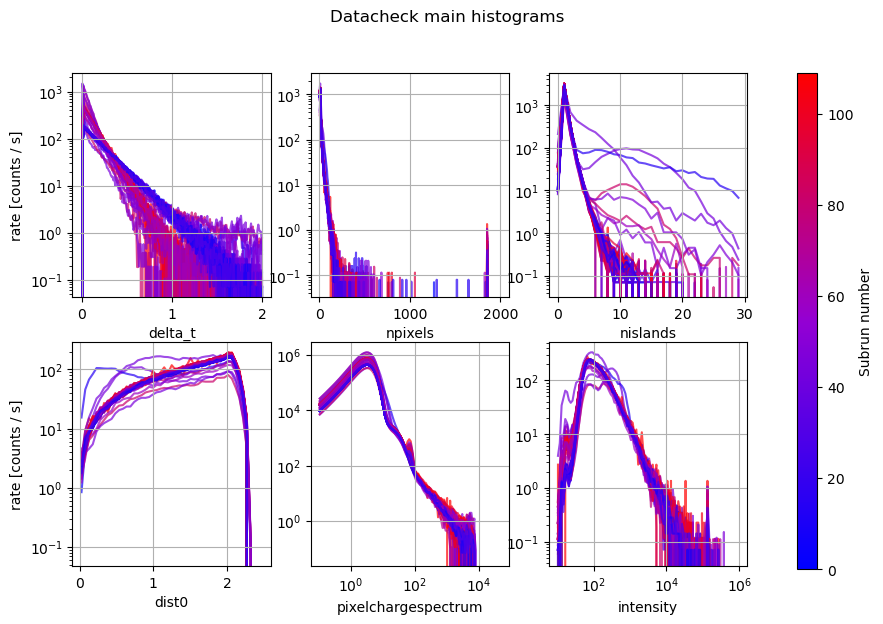

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6.4))
fig.suptitle(f"Datacheck main histograms")

srun_number = np.arange(len(hist_delta_t))
colors_cmap = plotting.get_colors_multiplot(srun_number, input_colors=cmap_cols)


for i in range(len(hist_delta_t)):
    random_zorder = np.random.rand()
    axs[0, 0].plot((bins_hist_delta_t[1:] + bins_hist_delta_t[:-1])/2, 
                   hist_delta_t[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[0, 1].plot((bins_hist_npixels[1:] + bins_hist_npixels[:-1])/2, 
                   hist_npixels[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[0, 2].plot((bins_hist_nislands[1:] + bins_hist_nislands[:-1])/2, 
                   hist_nislands[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 0].plot((bins_hist_dist0[1:] + bins_hist_dist0[:-1])/2, 
                   hist_dist0[i] / srun_elapsed_time[i],
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 1].plot((bins_hist_pixelchargespectrum[1:] * bins_hist_pixelchargespectrum[:-1])**0.5,
                   hist_pixelchargespectrum[i] / srun_elapsed_time[i], 
                   color=colors_cmap[i], zorder=random_zorder, alpha=0.7)
    axs[1, 2].plot((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5, 
                   hist_intensity[i] / srun_elapsed_time[i], 
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)

axs[0, 0].set_xlabel("delta_t")
axs[0, 1].set_xlabel("npixels")
axs[0, 2].set_xlabel("nislands")
axs[1, 0].set_xlabel("dist0")
axs[1, 1].set_xlabel("pixelchargespectrum")
axs[1, 2].set_xlabel("intensity")
axs[1, 1].set_xscale("log")
axs[1, 2].set_xscale("log")

cmap = plotting.create_cmap_from_colors(cmap_cols)
norma = matplotlib.colors.Normalize(vmin=min(srun_number), vmax=max(srun_number))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norma)
sm.set_array([])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.105, 0.02, 0.775])
fig.colorbar(sm, cax=cbar_ax, label="Subrun number")


for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i, j].set_yscale("log")
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("rate [counts / s]")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_datacheck distributions_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### Calculating dR/dI
We defined dR/dI as a good parameter to study cosmic ray rates, that dominate over gamma ray rates. So studing and parameterizing the intensity spectrum we can study the cosmic ray rate changes.

In [6]:
# --- reference values for drdi calculation --- #
ref_p0 =  1.74 
ref_p1 = -2.23
ref_intensity = 422
# --------------------------------------------- #

drdi_p0, drdi_delta_p0 = [], []
drdi_p1, drdi_delta_p1 = [], []
drdi_chi2, drdi_pvalue = [], []

for i in range(len(hist_intensity)):

    x_fit = ((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5)[28:35] / ref_intensity
    y_fit = (hist_intensity[i] / srun_elapsed_time[i] / np.diff(bins_hist_intensity))[28:35]
    yerr_fit = (np.sqrt(hist_intensity[i]) / srun_elapsed_time[i] / np.diff(bins_hist_intensity))[28:35]

    params, pcov, info, _, _ = curve_fit(
        f     = utils.powerlaw,
        xdata = x_fit,
        ydata = y_fit,
        sigma = yerr_fit,
        p0    = [ref_p0, ref_p1],
        full_output = True,
    )

    _p0, _p1  = params
    _delta_p0, _delta_p1 = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])
    _chi2     = np.sum(info["fvec"] ** 2)
    _pvalue   = 1 - chi2.cdf(_chi2, len(x_fit))
    
    drdi_p0.append(_p0)
    drdi_delta_p0.append(_delta_p0)
    drdi_p1.append(_p1)
    drdi_delta_p1.append(_delta_p1)
    drdi_chi2.append(_chi2)
    drdi_pvalue.append(_pvalue)

drdi_p0, drdi_delta_p0 = np.array(drdi_p0), np.array(drdi_delta_p0)
drdi_p1, drdi_delta_p1 = np.array(drdi_p1), np.array(drdi_delta_p1)
drdi_chi2, drdi_pvalue = np.array(drdi_chi2), np.array(drdi_pvalue)    

##### Ploting dR/dI and rates
We are going to plot together firts, the intensity spectrums and then the space parameter of the average rate and the dRdI values for each subrun.

Then also the time evolution of these parameters, as well as the slope of the power law fit and the chi square of the fit are plotted below.

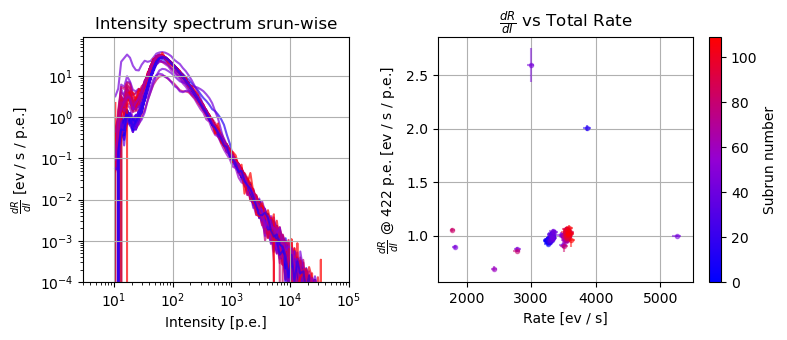

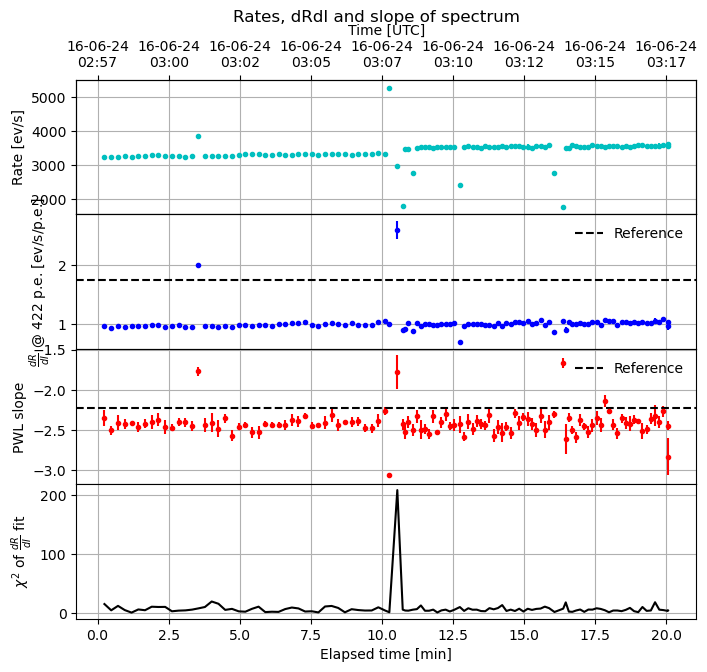

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5), gridspec_kw={'width_ratios': [1, 1.2]})

srun_number = np.arange(len(hist_delta_t))
colors_cmap = plotting.get_colors_multiplot(srun_number, input_colors=cmap_cols)

for i in range(len(hist_delta_t)):
    random_zorder = np.random.rand()
    ax1.plot((bins_hist_intensity[1:] * bins_hist_intensity[:-1])**0.5, 
                   hist_intensity[i] / srun_elapsed_time[i] / np.diff(bins_hist_intensity), 
                  color=colors_cmap[i], zorder=random_zorder, alpha=0.7)

    ax2.errorbar(srun_rate_cleaned_events[i], drdi_p0[i], xerr=np.sqrt(srun_rate_cleaned_events)[i],
                 yerr=drdi_delta_p0[i], alpha=0.5, ls="", color=colors_cmap[i], marker=".")


cmap = plotting.create_cmap_from_colors(cmap_cols)
plotting.plot_colorbar(fig, ax2, range(len(srun_number)), cmap=cmap, label="Subrun number")

for ax in [ax1, ax2]:
    ax.grid()
ax1.loglog()
ax1.set_ylim(1e-4)
ax1.set_xlim(3e0, 1e5)
ax1.set_xlabel("Intensity [p.e.]")
ax1.set_ylabel("$\\frac{dR}{dI}$ [ev / s / p.e.]")
ax2.set_xlabel("Rate [ev / s]")
ax2.set_ylabel("$\\frac{dR}{dI}$ @ 422 p.e. [ev / s / p.e.]")
ax1.set_title("Intensity spectrum srun-wise")
ax2.set_title("$\\frac{dR}{dI}$ vs Total Rate")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_drdi_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()



fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(8, 7), sharex=True)

ax0.errorbar(srun_cumulative_time / 60, srun_rate_cleaned_events, yerr=np.sqrt(srun_rate_cleaned_events),
             color="c", fmt=".",)
ax1.errorbar(srun_cumulative_time / 60, drdi_p0, yerr=drdi_delta_p0, fmt=".", color="b",)
ax1.axhline(ref_p0, ls="--", color="k", label="Reference")
ax2.errorbar(srun_cumulative_time / 60, drdi_p1, yerr=drdi_delta_p1, fmt=".", color="r",)
ax2.axhline(ref_p1, ls="--", color="k", label="Reference")
ax3.plot(srun_cumulative_time / 60, drdi_chi2, marker="", label="chi2", color="k")


ax0.set_ylabel("Rate [ev/s]")
ax1.set_ylabel("$\\frac{dR}{dI}$ @ 422 p.e. [ev/s/p.e.]")
ax2.set_ylabel("PWL slope")
ax3.set_ylabel("$\\chi^2$ of $\\frac{dR}{dI}$ fit")
ax3.set_xlabel("Elapsed time [min]")

for ax in [ax0, ax1, ax2, ax3]:
    ax.grid()
    if ax in [ax1, ax2]:
        ax.legend(frameon=False)

axtop = ax0.twiny()
axtop.set_xticks(ax2.get_xticks()[:])
axtop.set_xticklabels(ax2.get_xticklabels()[:])
init_date  = datetime.fromtimestamp(srun_dragon_time[0])
tick_dates = [init_date + timedelta(minutes=t) for t in ax2.get_xticks()]
tick_labels = [t.strftime('%d-%m-%y\n%H:%M') for t in tick_dates]
axtop.set_xticklabels(tick_labels)
axtop.set_xlim(ax2.get_xlim())
axtop.set_xlabel("Time [UTC]")
fig.suptitle("Rates, dRdI and slope of spectrum")
plt.subplots_adjust(wspace=0, hspace=0)

if store_plots == True:
    plt.savefig(dir_plots + f"plot_rates_evolution_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

#### Average distributions in camera coordinates
Some of the DL1 and DL2 data can be plotted in camera coordinates (x, y) in order to see if we see something strange or dome non homogeneous distribution. In order to detect irregularities in the observations in a spatial sense of view.

For DL1:
* Event count
* Psi angle
* Width
* Length

For DL2:
* Event count
* Timestamp
* Energy
* Gammaness

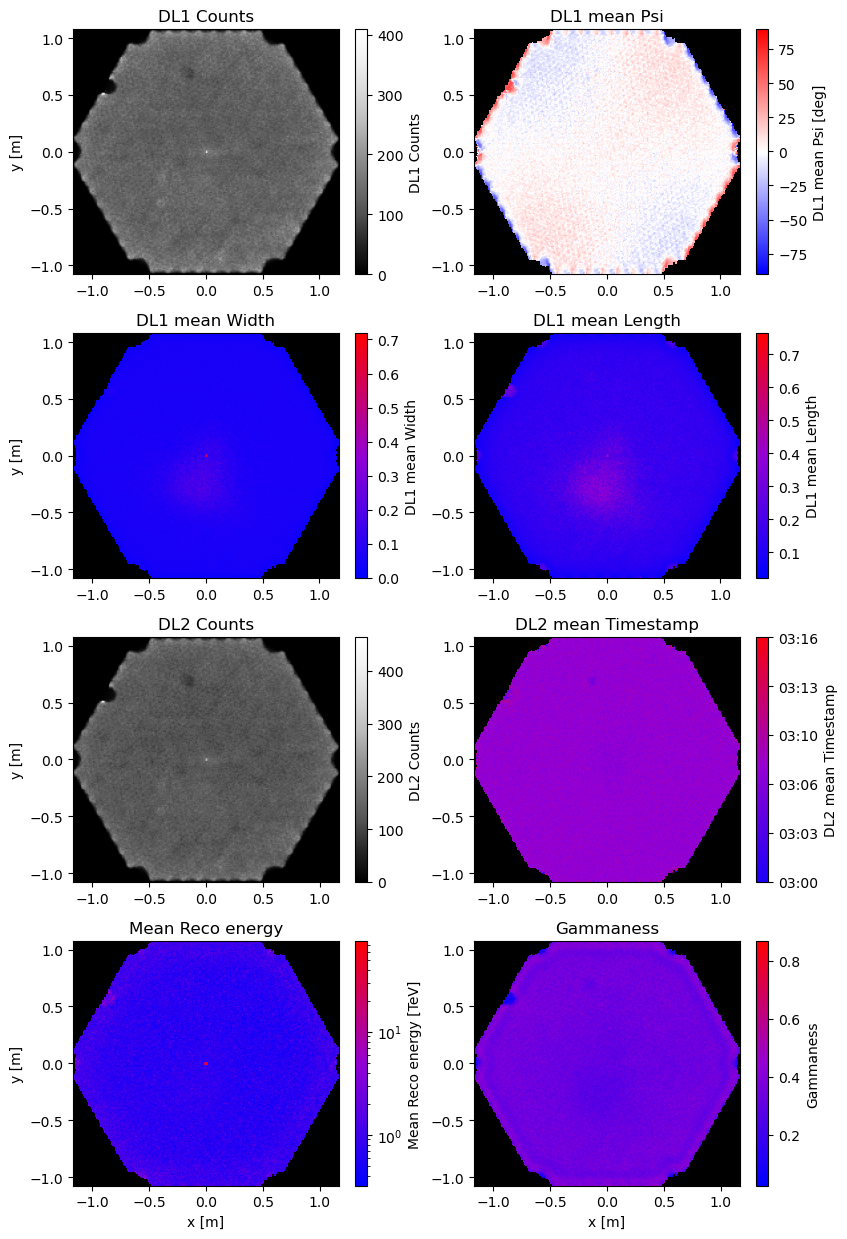

In [8]:
nbins = 200

if path_dl2 == None:
    fig, ax = plt.subplots(2, 2, figsize=(8.5, 6.25))
else:
    fig, ax = plt.subplots(4, 2, figsize=(8.5, 12.5))

hist1, x_edge, y_edge = np.histogram2d(dl1_x, dl1_y, nbins)
im0 = ax[0,0].imshow(hist1.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), origin="lower", cmap="Greys_r")


statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, np.rad2deg(dl1_psi), statistic="mean", bins=nbins)
im1 = ax[0,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap="bwr")

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, dl1_width, statistic="mean", bins=nbins)
im2 = ax[1,0].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap=cmap)

statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl1_x, dl1_y, dl1_length, statistic="mean", bins=nbins)
im3 = ax[1,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                    origin="lower", cmap=colormap)

if path_dl2 != None:
    hist2, x_edge, y_edge = np.histogram2d(dl2_x, dl2_y, nbins)
    im4 = ax[2,0].imshow(hist2.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), origin="lower", cmap="Greys_r")

    statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_dragontime, statistic="mean", bins=nbins)
    im5 = ax[2,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                        origin="lower", cmap=colormap)

    statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_energy, statistic="mean", bins=nbins)
    im6 = ax[3,0].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                        origin="lower", cmap=colormap, norm=matplotlib.colors.LogNorm())

    statistic, x_edge, y_edge, binnumber = binned_statistic_2d(dl2_x, dl2_y, dl2_gammaness, statistic="mean", bins=nbins)
    im7 = ax[3,1].imshow(statistic.T, extent=(x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]), 
                        origin="lower", cmap=colormap,)

    fig.colorbar(im4, ax=ax[2,0], label="DL2 Counts")
    ax[2,0].set_title("DL2 Counts")
    cbar = fig.colorbar(im5, ax=ax[2,1], label="DL2 mean Timestamp")
    cbar.ax.set_yticks(cbar.ax.get_yticks())
    cbar.ax.set_yticklabels([datetime.fromtimestamp(t).strftime('%H:%M') for t in cbar.ax.get_yticks()])
    cbar.ax.set_ylim(cbar.ax.get_yticks()[1]-0.1, cbar.ax.get_yticks()[-2]+0.1)
    ax[2,1].set_title("DL2 mean Timestamp") 
    fig.colorbar(im6, ax=ax[3,0], label="Mean Reco energy [TeV]")
    ax[3,0].set_title("Mean Reco energy")
    fig.colorbar(im7, ax=ax[3,1], label="Gammaness")
    ax[3,1].set_title("Gammaness")    
    
    
fig.colorbar(im0, ax=ax[0,0], label="DL1 Counts")
ax[0,0].set_title("DL1 Counts")
fig.colorbar(im1, ax=ax[0,1], label="DL1 mean Psi [deg]")
ax[0,1].set_title("DL1 mean Psi")
fig.colorbar(im2, ax=ax[1,0], label="DL1 mean Width")
ax[1,0].set_title("DL1 mean Width")
fig.colorbar(im3, ax=ax[1,1], label="DL1 mean Length")
ax[1,1].set_title("DL1 mean Length")

for i in range(len(ax)):
    for j in range(len(ax[i])):
        index_xlabel = 3 if path_dl2 != None else 1

        if i == index_xlabel:
            ax[i,j].set_xlabel("x [m]")
        if j == 0:
            ax[i,j].set_ylabel("y [m]")
        if not (i == 0 and j == 0):
            ax[i,j].set_facecolor("k")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_camera_distribution_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### Computing coordinates in RA-DEC from ALT-AZ
In order to plot the pointing parameters, we need to do some coordinate transformations using astropy.

In [9]:
%%time
numskip = 10000

dl1_time_coords = np.array(dl1_dragontime[::numskip])

dl1_alt_tel, dl1_az_tel = np.array(dl1_alt_tel_total[::numskip]), np.array(dl1_az_tel_total[::numskip])

dl1_alt_source, dl1_az_source = [], []
for i, t in enumerate(dl1_time_coords):
    altaz = AltAz(location=observing_location, obstime=datetime.fromtimestamp(t))
    coord_altaz = source_coord.transform_to(altaz)

    _az, _alt  = coord_altaz.az, coord_altaz.alt
    dl1_alt_source.append(_alt.value)
    dl1_az_source.append(_az.value)

dl1_alt_source = np.array(dl1_alt_source)
dl1_az_source = np.array(dl1_az_source)

# Converting alt az of telescope to ra dec
dl1_ra_tel, dl1_dec_tel = [], []
for j in range(len(dl1_az_tel)):
    altaz = AltAz(
        alt = dl1_alt_tel[j] * u.deg,
        az = dl1_az_tel[j] * u.deg, 
        obstime = datetime.fromtimestamp(dl1_time_coords[j]), 
        location = observing_location
    )
    skycoord_altaz = SkyCoord(altaz)
    skycoord_icrs = skycoord_altaz.transform_to("icrs")
    dl1_ra_tel.append(skycoord_icrs.ra.deg)
    dl1_dec_tel.append(skycoord_icrs.dec.deg)

dl1_ra_tel = np.array(dl1_ra_tel)
dl1_dec_tel = np.array(dl1_dec_tel)

# Computing separations
dl1_separation = []
for i in range(len(dl1_ra_tel)):
    coords = SkyCoord(ra=dl1_ra_tel[i], dec=dl1_dec_tel[i], unit="deg")
    dl1_separation.append(source_coord.separation(coords).deg)

CPU times: user 6.46 s, sys: 106 ms, total: 6.57 s
Wall time: 6.57 s


##### Plotting the coordinates and pointing separation
After computations we can plot the coordinates of the pointing in ALT-AZ and RA-DEC

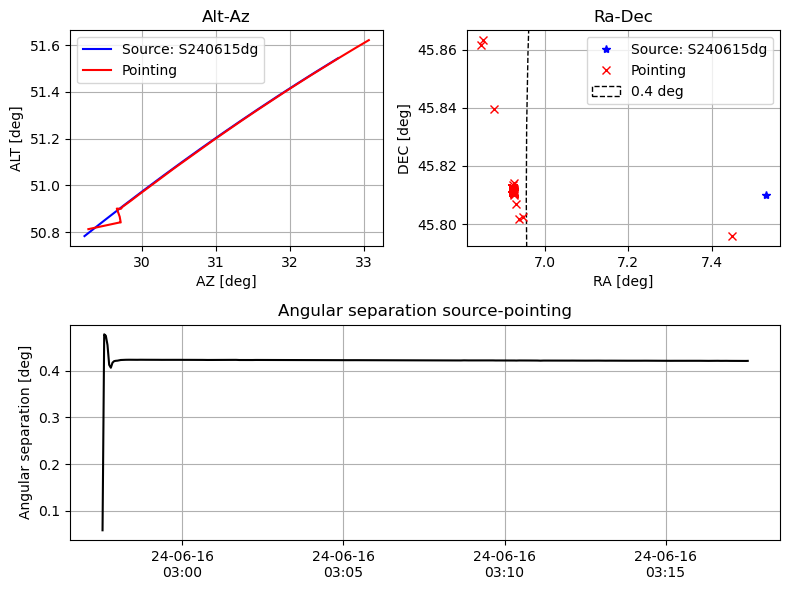

In [10]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.plot(dl1_alt_source, dl1_az_source, ls="-", marker="", color="b", label=f"Source: {source_name}")
ax1.plot(dl1_alt_tel, dl1_az_tel, ls="-", marker="", color="r", label="Pointing")

ax2.plot(source_ra, source_dec, ls="", marker="*", color="b", label=f"Source: {source_name}")
ax2.plot(dl1_ra_tel, dl1_dec_tel, ls="", marker="x", color="r", label="Pointing")

_xlim = ax2.get_xlim()
_ylim = ax2.get_ylim()
Circle = SphericalCircle(
        SkyCoord(source_coord, unit="deg"), 0.4 * u.deg, 
        ls="--", ec="k", fc="none", label="0.4 deg"
)
ax2.add_patch(Circle)

ax3.plot([datetime.fromtimestamp(t) for t in dl1_time_coords], dl1_separation, marker="", ls="-", color="k")

ax2.set_xlim(_xlim)
ax2.set_ylim(_ylim)

for ax in [ax1, ax2, ax3]:
    ax.grid()
    if ax != ax3:
        ax.legend()
ax1.set_xlabel("AZ [deg]")
ax1.set_ylabel("ALT [deg]")
ax2.set_xlabel("RA [deg]")
ax2.set_ylabel("DEC [deg]")
ax3.set_ylabel("Angular separation [deg]")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d\n%H:%M"))
ax1.set_title("Alt-Az")
ax2.set_title("Ra-Dec")
ax3.set_title("Angular separation source-pointing")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_pointing_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### Some counts map
We can also, regarding the events, having reconstructed DL2 data, the event count map. That will show us the distribution of the events in the sky.

<span style="color:red"> *(This can be done only with DL1 data, but requires a coordinate change of all events to RA-DEC frame, what is quite expensive computationally, so in this script we are using the already computed data inside DL3, so if DL3 is not present this part will be skipped.)* </span>

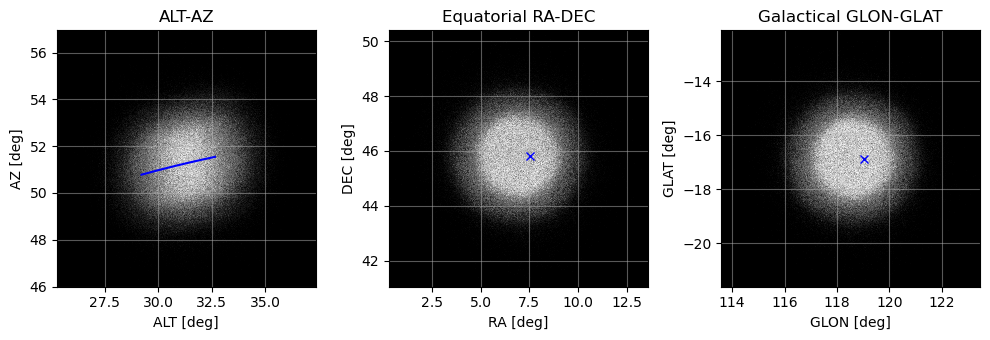

In [11]:
nbins = 300

fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

ax[0].hist2d(dl3_alt, dl3_az, bins=nbins, cmap="Greys_r")
ax[1].hist2d(dl3_ra, dl3_dec, bins=nbins, cmap="Greys_r")
ax[2].hist2d(dl3_glon, dl3_glat, bins=nbins, cmap="Greys_r")

ax[0].plot(dl1_alt_source, dl1_az_source, ls="-", marker="", color="b", label=f"Source: {source_name}")
ax[1].plot(source_ra, source_dec, ls="", marker="x", color="b", label=f"Source: {source_name}")
ax[2].plot(source_glon, source_glat, ls="", marker="x", color="b", label=f"Source: {source_name}")

ax[0].set_xlabel("ALT [deg]")
ax[1].set_xlabel("RA [deg]")
ax[2].set_xlabel("GLON [deg]")
ax[0].set_ylabel("AZ [deg]")
ax[1].set_ylabel("DEC [deg]")
ax[2].set_ylabel("GLAT [deg]")
for i in range(len(ax)):
    ax[i].grid(alpha=0.5)
ax[0].set_title("ALT-AZ")
ax[1].set_title("Equatorial RA-DEC")
ax[2].set_title("Galactical GLON-GLAT")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_counts_maps_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

High and low energy count map.

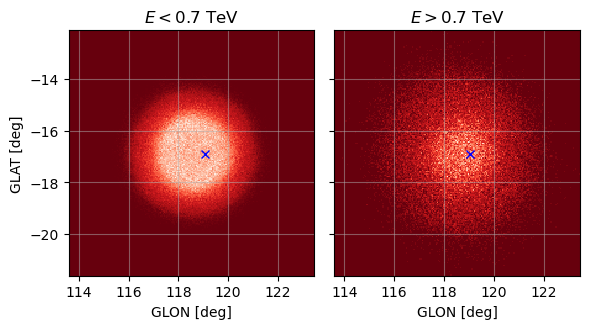

In [12]:
nbins = 200

threshold_energy = 0.7 # TeV

mask_low = dl3_energy < threshold_energy
mask_high = dl3_energy > threshold_energy

bins_glon = np.linspace(np.min(dl3_glon), np.max(dl3_glon), nbins)
bins_glat = np.linspace(np.min(dl3_glat), np.max(dl3_glat), nbins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.4), sharex=True, sharey=True)

ax1.hist2d(dl3_glon[mask_low], dl3_glat[mask_low], bins=(bins_glon, bins_glat), cmap="Reds_r")
ax2.hist2d(dl3_glon[mask_high], dl3_glat[mask_high], bins=(bins_glon, bins_glat), cmap="Reds_r")

ax1.plot(source_glon, source_glat, ls="", marker="x", color="b", label=f"Source: {source_name}")
ax2.plot(source_glon, source_glat, ls="", marker="x", color="b", label=f"Source: {source_name}")

ax1.set_xlabel("GLON [deg]")
ax2.set_xlabel("GLON [deg]")
ax1.set_ylabel("GLAT [deg]")
for ax in [ax1, ax2]:
    ax.grid(alpha=0.5)
ax1.set_title(f"$E < {threshold_energy}$ TeV")
ax2.set_title(f"$E > {threshold_energy}$ TeV")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_counts_map_energy_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

High and low gammaness count map.

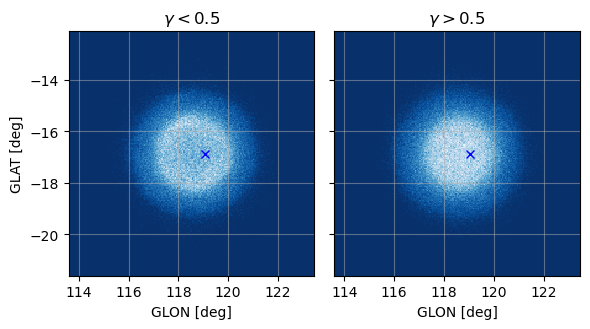

In [13]:
nbins = 200

threshold_gh = 0.5

mask_low = dl3_gammaness < threshold_energy
mask_high = dl3_gammaness > threshold_energy

bins_glon = np.linspace(np.min(dl3_glon), np.max(dl3_glon), nbins)
bins_glat = np.linspace(np.min(dl3_glat), np.max(dl3_glat), nbins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.4), sharex=True, sharey=True)

ax1.hist2d(dl3_glon[mask_low], dl3_glat[mask_low], bins=(bins_glon, bins_glat), cmap="Blues_r")
ax2.hist2d(dl3_glon[mask_high], dl3_glat[mask_high], bins=(bins_glon, bins_glat), cmap="Blues_r")

ax1.plot(source_glon, source_glat, ls="", marker="x", color="b", label=f"Source: {source_name}")
ax2.plot(source_glon, source_glat, ls="", marker="x", color="b", label=f"Source: {source_name}")

ax1.set_xlabel("GLON [deg]")
ax2.set_xlabel("GLON [deg]")
ax1.set_ylabel("GLAT [deg]")
ax1.set_title(f"$\gamma < {threshold_gh}$")
ax2.set_title(f"$\gamma > {threshold_gh}$")
for ax in [ax1, ax2]:
    ax.grid(alpha=0.5)
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_counts_map_gammaness_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### MC available nodes

In [14]:
node_names = glob.glob(test_nodes_folders)
node_names = [f.split("/")[-1] for f in node_names]
node_zd = np.array([float(f.split("_")[2]) for f in node_names])
node_az = np.array([float(f.split("_")[4]) for f in node_names])

def angular_distance(alt1, az1, alt2, az2):
    alt1, az1 = np.radians(alt1), np.radians(az1)
    alt2, az2 = np.radians(alt2), np.radians(az2)
    cos_d = np.sin(alt1) * np.sin(alt2) + np.cos(alt1) * np.cos(alt2) * np.cos(az1 - az2)
    return np.degrees(np.arccos(cos_d)) 

needed_nodes, needed_indexes = [], []

print(f"Run {run_number}")
_alt, _az = np.mean(dl1_alt_tel), np.mean(dl1_az_tel)

distances = np.vectorize(angular_distance)(_alt, _az, 90 - node_zd, node_az)
indexes_min_dist = np.argsort(distances)
for j in [0, 1, 2]:
    print(f"  {j}st Closer: {node_names[indexes_min_dist[j]]} \t- dist {distances[indexes_min_dist[j]]:.2f} deg")    
    needed_nodes.append(node_names[indexes_min_dist[j]])
    needed_indexes.append(indexes_min_dist[j])

needed_nodes = np.unique(np.sort(needed_nodes))
needed_indexes = np.unique(np.sort(needed_indexes))

Run 17821
  0st Closer: node_theta_52.374_az_49.119_ 	- dist 6.50 deg
  1st Closer: node_theta_56.633_az_32.786_ 	- dist 15.72 deg
  2st Closer: node_theta_57.995_az_32.762_ 	- dist 15.74 deg


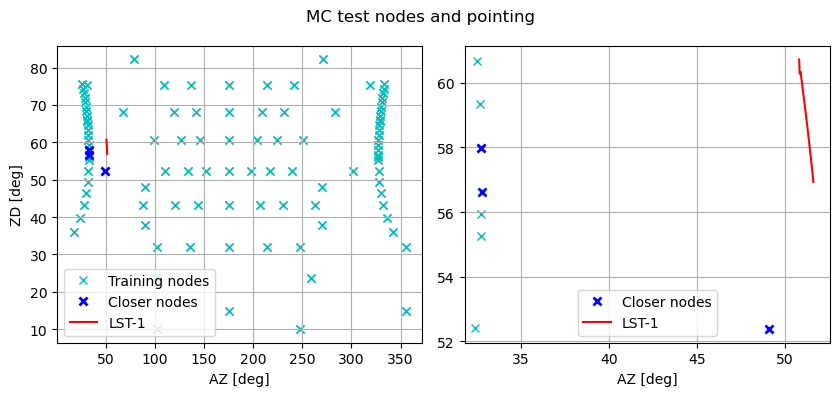

In [15]:
fig, (ax, axz) = plt.subplots(1, 2, figsize=(8.5, 4))

for axe in [ax, axz]:
   
    axe.plot(dl1_az_tel, 90 - dl1_alt_tel, color="r", )
    ax.plot(node_az, node_zd, ls="", marker="x", color="c", label="Training nodes", zorder=-20)
    axe.plot(node_az[needed_indexes], node_zd[needed_indexes], ls="", mew=2, marker="x", color="b", 
             label="Closer nodes")
    
    axe.plot([], [], color="r", ls="-", label="LST-1")
    axe.set_xlabel("AZ [deg]")
    axe.grid()
    axe.legend(loc="best", frameon=True)
    

_xlims, _ylims = axz.get_xlim(), axz.get_ylim()
axz.plot(node_az, node_zd, ls="", marker="x", color="c", label="Training nodes", zorder=-20)
axz.set_xlim(_xlims)
axz.set_ylim(_ylims)
ax.set_ylabel("ZD [deg]")
fig.suptitle("MC test nodes and pointing")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_mc_nodes_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### Deadtime distributions

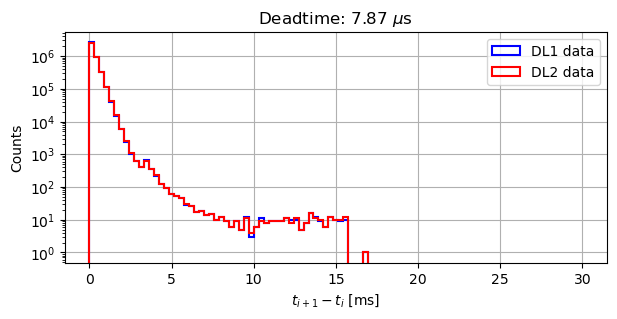

In [16]:
bins_tdiff = np.linspace(0, 0.03 * 1e3, 100)

fig, ax = plt.subplots(figsize=(7, 3))

ax.hist(dl1_timediff * 1e3, bins=bins_tdiff, histtype="step", lw=1.5, label="DL1 data", color="b")
if path_dl2 != None:
    ax.hist(dl2_timediff * 1e3, bins=bins_tdiff, histtype="step", lw=1.5, label="DL2 data", color="r")

ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$t_{i+1}-t_{i}$ [ms]")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title(f"Deadtime: {np.min(np.abs(dl1_timediff))*1e6:.3} $\mu$s")

if store_plots == True:
    plt.savefig(dir_plots + f"plot_deadtime_and_gammaness_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### NSB evolution

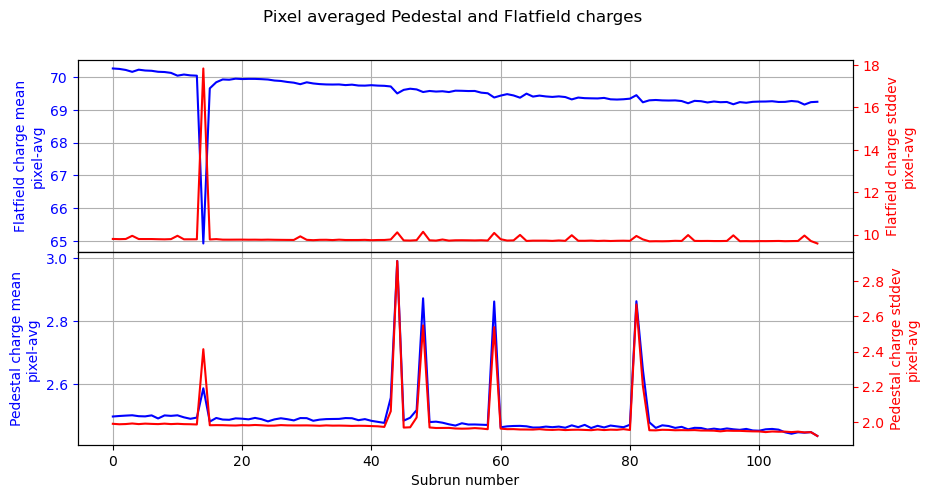

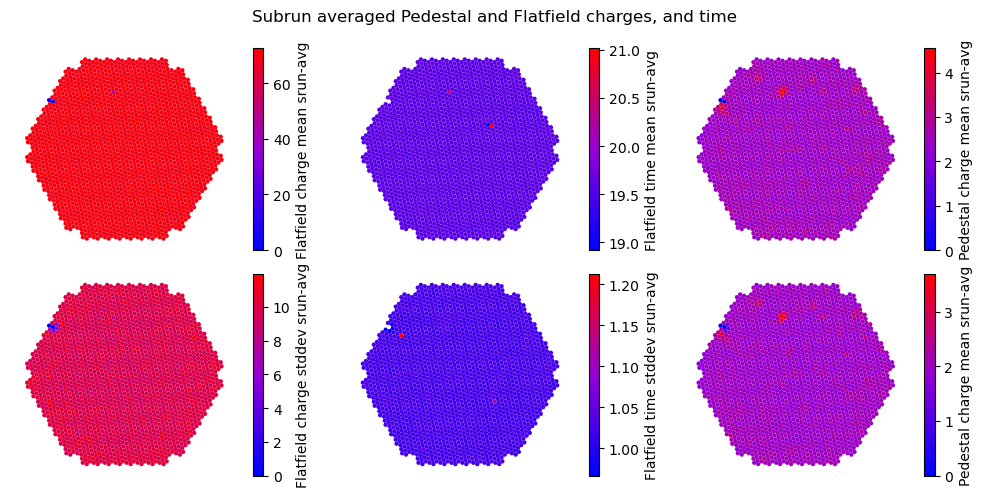

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

ax1t = ax1.twinx()
ax2t = ax2.twinx()

ax1.plot(srun_number, flatfield_charge_mean_srun, ls="-", marker="", color="blue")
ax1t.plot(srun_number, flatfield_charge_stddev_srun, ls="-", marker="", color="red")

ax2.plot(srun_number, pedestals_charge_mean_srun, ls="-", marker="", color="blue")
ax2t.plot(srun_number, pedestals_charge_stddev_srun, ls="-", marker="", color="red")

# Changing y axis colors
for ax in [ax1, ax2]:
    ax.yaxis.label.set_color("blue")
    ax.tick_params(axis="y", colors="blue")
    ax.grid()
for ax in [ax1t, ax2t]:
    ax.yaxis.label.set_color("red")
    ax.tick_params(axis="y", colors="red")

ax2.set_xlabel("Subrun number")
ax1.set_ylabel("Flatfield charge mean\npixel-avg", color="blue")
ax2.set_ylabel("Pedestal charge mean\npixel-avg", color="blue")
ax1t.set_ylabel("Flatfield charge stddev\npixel-avg", color="red")
ax2t.set_ylabel("Pedestal charge stddev\npixel-avg", color="red")
fig.suptitle("Pixel averaged Pedestal and Flatfield charges")
plt.subplots_adjust(wspace=0.0, hspace=0.0)

if store_plots == True:
    plt.savefig(dir_plots + f"plot_pedestal_flatfield_pixel_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()



fig, ax = plt.subplots(2, 3, figsize=(10, 5))       
fig.suptitle("Subrun averaged Pedestal and Flatfield charges, and time")

image = flatfield_charge_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,0], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Flatfield charge mean srun-avg", ax=ax[0,0])

image = flatfield_charge_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,0], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Flatfield charge stddev srun-avg", ax=ax[1,0])

image = flatfield_time_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,1], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Flatfield time mean srun-avg", ax=ax[0,1])

image = flatfield_time_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,1], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Flatfield time stddev srun-avg", ax=ax[1,1])

image = pedestals_charge_mean_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[0,2], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Pedestal charge mean srun-avg", ax=ax[0,2])

image = pedestals_charge_stddev_pixel
camdisplay = CameraDisplay(camgeom, ax=ax[1,2], image=image, show_frame=False, cmap=colormap, title="")
camdisplay.add_colorbar(label="Pedestal charge mean srun-avg", ax=ax[1,2])

for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].axis("off")
fig.tight_layout()

if store_plots == True:
    plt.savefig(dir_plots + f"plot_pedestal_flatfield_srun_Run{run_number}.png", bbox_inches="tight", dpi=300)
plt.show()

##### Gammaness and theta cuts

In [18]:
if path_dl2 != None and path_dl3 != None:
    bins_gh = np.linspace(0, 1, 100)

    if "GH_CUTS" in dl3_key_names:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5), gridspec_kw={'width_ratios': [1, 1.7]})
        ax2t = ax2.twinx() if dl3_gh_cuts_nevs_bool != False else None

        ax1.hist(dl2_gammaness, bins=bins_gh, histtype="step", lw=1.5, label="DL1 data", color="b")


        ax2.errorbar(dl3_gh_cuts_bin_c, dl3_gh_cuts_val, xerr=(dl3_gh_cuts_bin_xerr_left, dl3_gh_cuts_bin_xerr_right),
                    color="b", marker=".", ls="--")

        # Changing y axis colors
        ax2.yaxis.label.set_color("blue")
        ax2.tick_params(axis="y", colors="blue")
        if dl3_gh_cuts_nevs_bool != False:
            ax2t.errorbar(dl3_gh_cuts_bin_c, dl3_gh_cuts_nevs, xerr=(dl3_gh_cuts_bin_xerr_left, dl3_gh_cuts_bin_xerr_right),
                        yerr=np.sqrt(dl3_gh_cuts_nevs), color="r", marker=".", ls="--")

            ax2t.yaxis.label.set_color("red")
            ax2t.tick_params(axis="y", colors="red")
            ax2t.set_yscale("log")
            ax2t.set_ylabel("Number of events", color="red")

        for ax in [ax1, ax2]:
            ax.grid()
        ax2.set_xscale("log")
        ax1.set_yscale("log")

        ax2.set_xlabel("Energy [TeV]")
        ax1.set_ylabel("Counts")
        ax1.set_xlabel("Gammaness")
        ax2.set_ylabel("Gammaness", color="blue")
        fig.suptitle("Gammaness distribution and cuts applied")
        fig.tight_layout()

        if store_plots == True:
            plt.savefig(dir_plots + f"plot_gammaness_cuts_Run{run_number}.png", bbox_inches="tight", dpi=300)
        plt.show()

    if "RAD_MAX" in dl3_key_names:
        fig, ax = plt.subplots(figsize=(5, 3))

        ax.errorbar(dl3_theta_cuts_bin_c, dl3_theta_cuts_val, 
                     xerr=(dl3_theta_cuts_bin_xerr_left, dl3_theta_cuts_bin_xerr_right),
                    color="b", marker=".", ls="--")

        ax.grid()
        ax.loglog()
        ax.set_xlabel("Energy [TeV]")
        ax.set_ylabel("$\\theta^2$ cut [deg]")
        ax.set_title("$\\theta^2$ cuts applied ")

        if store_plots == True:
            plt.savefig(dir_plots + f"plot_theta_cuts_Run{run_number}.png", bbox_inches="tight", dpi=300)
        plt.show()